The ideia is to fit a power law model to the stellar and to the total mass density profile.
The important parameter is the slope.

This is similar to that present in Li+16 and Xu+2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import least_squares

In [2]:
data_path = "/home/carlosmelo/Documents/GitHub/Illustris/my_illustris/TNG50-1-snap84-subhalo9/"
info = fits.open(data_path+"/imgs/log_img.fits")[1].data
sol, pa, eps, xmed, ymed = np.load(data_path+"/mge/mge.npy",  allow_pickle=True)


cosmo = FlatLambdaCDM(H0=float(info["H0"]), Om0=info["OMEGA0"])
distance = cosmo.angular_diameter_distance(info["redshift"]).value

In [16]:
pc       = distance*np.pi/0.648  # Constant factor to convert arcsec --> pc
reff     = 0.9365583424776649
reff_pc  = reff*pc

a = 0.5
b = 1
# Load DM density profile
dm_hdu = fits.open(data_path+"/dm/density_fit.fits")
rho_dm = dm_hdu[1].data["density"]
r_dm   = dm_hdu[1].data["radius"]

i = (a*reff_pc < r_dm) &  (r_dm < b*reff_pc)
log_rho_dm = np.log(rho_dm[i])
log_r_dm   = np.log(r_dm[i])

    # Load star density profile
star_hdu = fits.open(data_path+"/imgs/stellar_density.fits")
rho_star = star_hdu[1].data["density"]
r_star   = star_hdu[1].data["radius"]

i = (a*reff_pc < r_star) &  (r_star < b*reff_pc)
log_rho_star = np.log(rho_star[i])
log_r_star   = np.log(r_star[i])


    # Total mass density profile
rho_total = rho_dm + rho_star
r_total   = r_dm
log_rho_total = np.log(rho_total[i])
log_r_total   = np.log(r_total[i])

In [17]:
def model(theta, x):
    return theta[0]*x + theta[1]

def fit(theta, log_rho, log_r):
    return model(theta, log_r) - log_rho

In [18]:
theta0 = [-2, 2]
fit_star  = least_squares(fit, theta0, args=(log_rho_star,  log_r_star))
fit_dm    = least_squares(fit, theta0, args=(log_rho_dm,    log_r_dm))
fit_total = least_squares(fit, theta0, args=(log_rho_total, log_r_total))

In [19]:
bestfit_star  = model(fit_star.x, log_r_star)
bestfit_dm    = model(fit_dm.x, log_r_dm)
bestfit_total = model(fit_total.x, log_r_total)


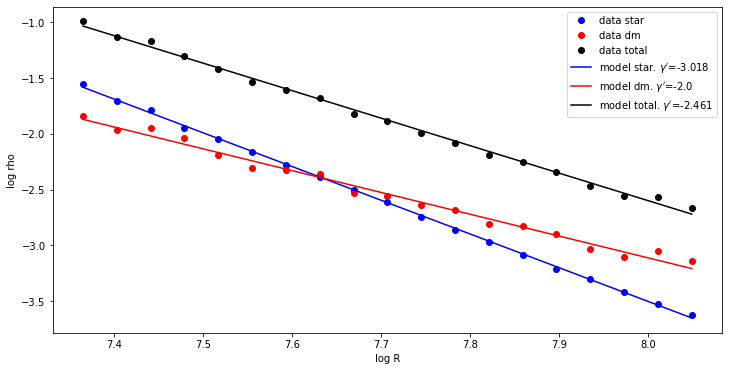

In [20]:
plt.figure(figsize=(12,6))
plt.plot(log_r_star,  log_rho_star,  "o", label="data star", color="blue")
plt.plot(log_r_dm,    log_rho_dm,    "o", label="data dm", color="red")
plt.plot(log_r_total, log_rho_total, "o", label="data total", color="black")

plt.plot(log_r_star,  bestfit_star, label="model star. $\gamma^\prime$={:.4}".format(fit_star.x[0]), color="blue")
plt.plot(log_r_dm,    bestfit_dm, label="model dm. $\gamma^\prime$={:.2}".format(fit_dm.x[0]), color="red")
plt.plot(log_r_total, bestfit_total, label="model total. $\gamma^\prime$={:.4}".format(fit_total.x[0]), color="black")

plt.xlabel("log R")
plt.ylabel("log rho")
plt.legend()

In [21]:
from scipy import interpolate

In [22]:
f_star = interpolate.interp1d(r_star, rho_star)

In [23]:
np.log( f_star(b*reff_pc) / f_star(a*reff_pc) ) / np.log( (a*reff_pc) / (b*reff_pc) )

array([3.01751118])

In [24]:
f_total = interpolate.interp1d(r_total, rho_total, kind="cubic")

In [25]:
np.log( f_total(b*reff_pc) / f_total(a*reff_pc) ) / np.log( (a*reff_pc) / (b*reff_pc) )

array([2.43464364])

----